In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
df = pd.read_csv(
    r"C:\Users\sijan\AI CourseWork\Capital_Project_Schedules_and_Budgets.csv",
    encoding="utf-8"
)


print("\n--- Dataset Loaded ---")
print(f"Shape: {df.shape}")

print("\n--- Column Info ---")
print(df.info())

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Missing Values (%) ---")
missing_pct = (df.isnull().sum() / len(df)) * 100
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

print(f"\n--- Duplicate Rows: {df.duplicated().sum()} ---")


--- Dataset Loaded ---
Shape: (13638, 14)

--- Column Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13638 entries, 0 to 13637
Data columns (total 14 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Project Geographic District                                 13638 non-null  int64  
 1   Project Building Identifier                                 13638 non-null  object 
 2   Project School Name                                         13638 non-null  object 
 3   Project Type                                                13638 non-null  object 
 4   Project Description                                         13638 non-null  object 
 5   Project Phase Name                                          13638 non-null  object 
 6   Project Status Name                                         13638 non-null  object 
 7   Project Phase Actual 

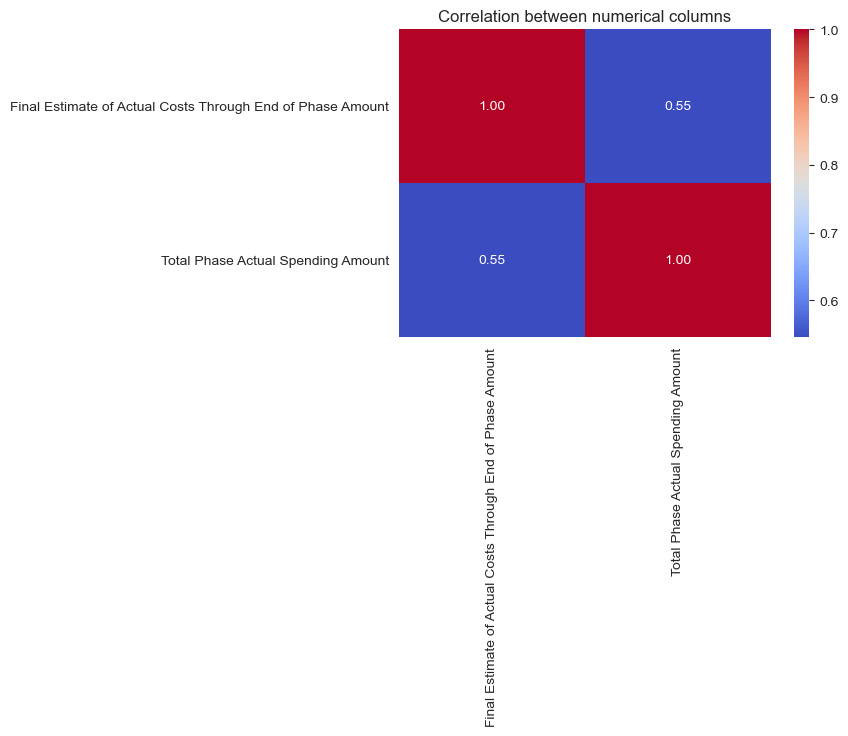

In [3]:
df["Project Phase Actual Start Date"] = pd.to_datetime(df["Project Phase Actual Start Date"], errors='coerce')
df["Project Phase Actual End Date"] = pd.to_datetime(df["Project Phase Actual End Date"], errors='coerce')

num_cols = ["Final Estimate of Actual Costs Through End of Phase Amount", 
            "Total Phase Actual Spending Amount"]

plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between numerical columns")
plt.show()

In [4]:
budget_cols = [
    "Project Budget Amount",
    "Final Estimate of Actual Costs Through End of Phase Amount",
    "Total Phase Actual Spending Amount"
]

for col in budget_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("\n--- Data Types After Cleaning Budget Columns ---")
print(df[budget_cols].dtypes)


--- Data Types After Cleaning Budget Columns ---
Project Budget Amount                                         float64
Final Estimate of Actual Costs Through End of Phase Amount    float64
Total Phase Actual Spending Amount                            float64
dtype: object


In [5]:
df_clean = df.dropna(
    subset=[
        "Project Budget Amount",
        "Final Estimate of Actual Costs Through End of Phase Amount"
    ]
).copy()

df_clean["Overrun"] = (
    df_clean["Final Estimate of Actual Costs Through End of Phase Amount"]
    > df_clean["Project Budget Amount"]
).astype(int)

print("\n--- Overrun Class Distribution ---")
print(df_clean["Overrun"].value_counts())



--- Overrun Class Distribution ---
Overrun
0    5744
1    2565
Name: count, dtype: int64


In [6]:
numeric_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove("Overrun")

for col in numeric_cols:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)


In [7]:
categorical_cols = df_clean.select_dtypes(include="object").columns.tolist()

for col in categorical_cols:
    df_clean[col].fillna("Unknown", inplace=True)


In [8]:
df_clean.columns = df_clean.columns.str.strip()

In [9]:
features = [
    "Project Geographic District",
    "Project Type",
    "Project Phase Name",
    "Project Budget Amount",
    "Project Description"
]

target = "Overrun"

X = df_clean[features]
y = df_clean[target]


In [10]:
numeric_features = [
    "Project Geographic District",
    "Project Budget Amount"
]

categorical_features = [
    "Project Type",
    "Project Phase Name"
]

text_feature = "Project Description"


In [11]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

text_transformer = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=150,
        stop_words="english",
        ngram_range=(1, 2)
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", text_transformer, text_feature)
    ]
)

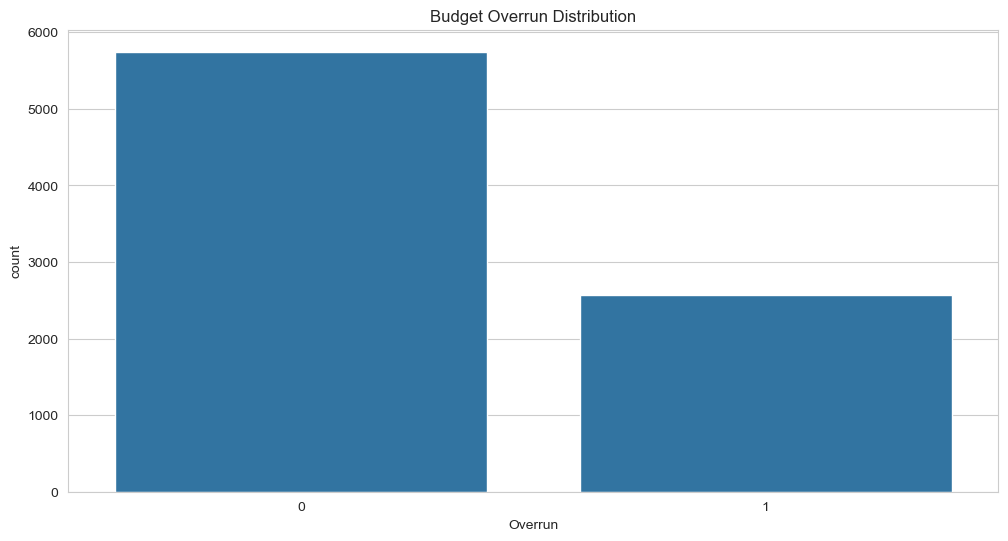

In [12]:
sns.countplot(x="Overrun", data=df_clean)
plt.title("Budget Overrun Distribution")
plt.show()


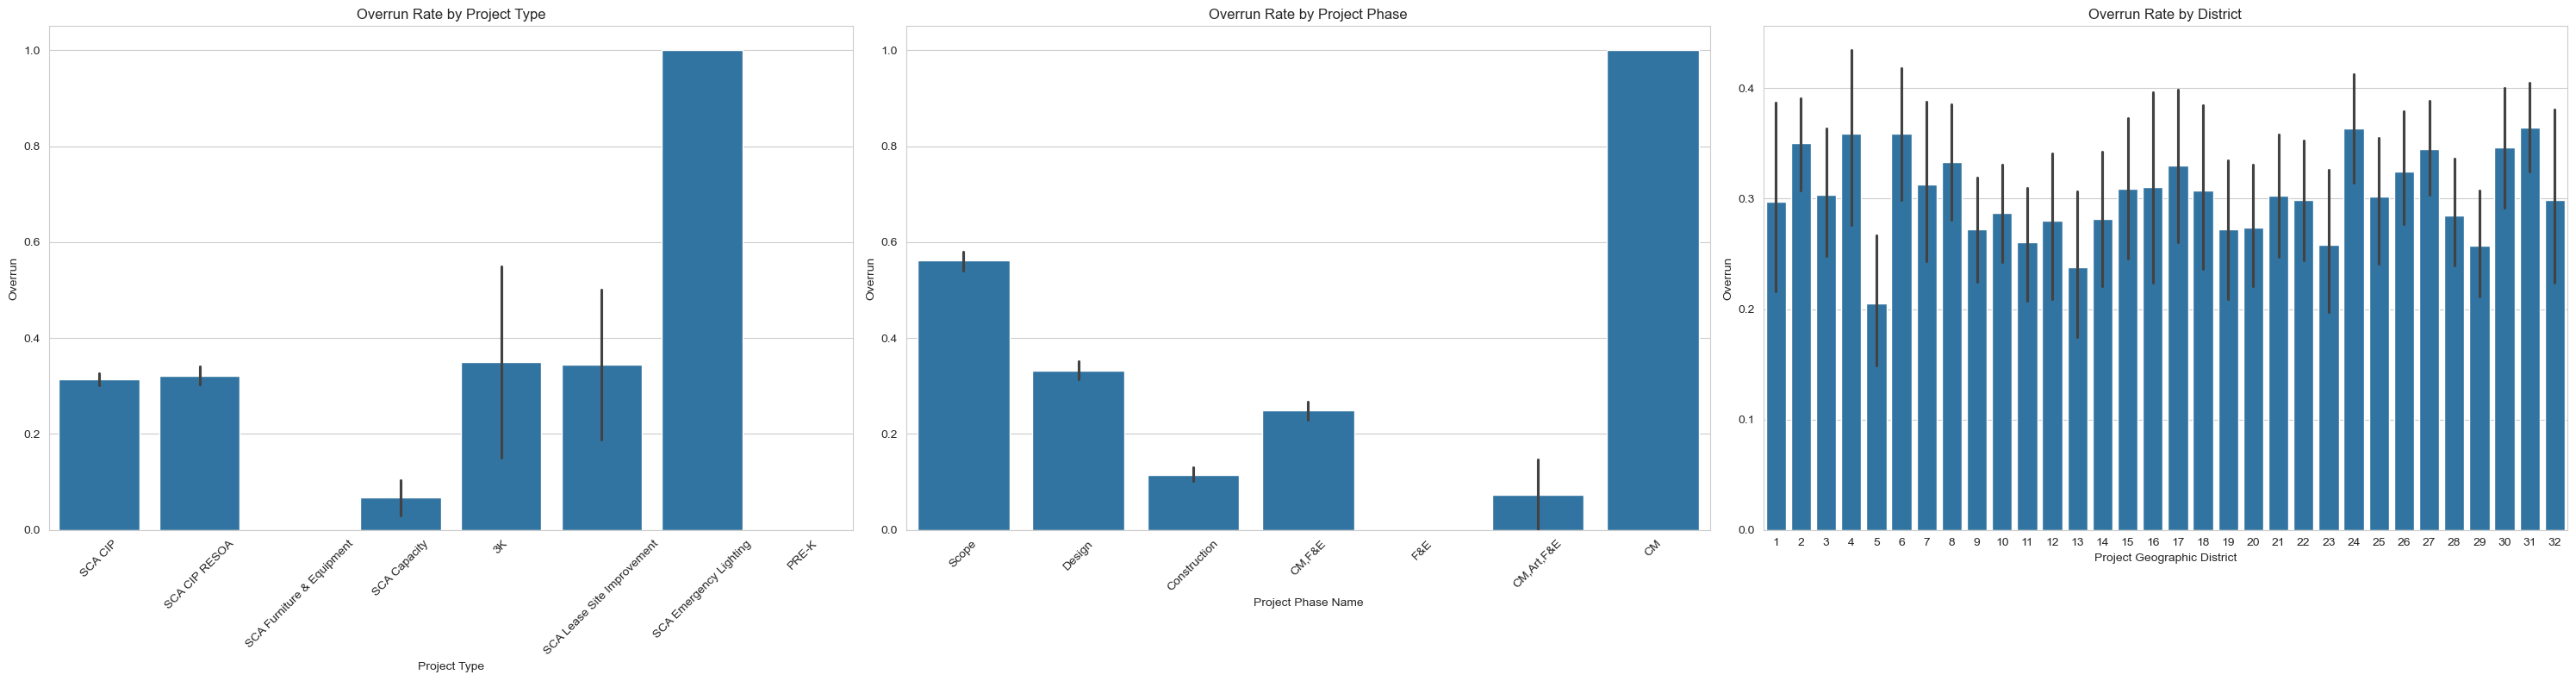

In [13]:
top_project_types = df_clean["Project Type"].value_counts().head(10).index
top_phases = df_clean["Project Phase Name"].value_counts().head(10).index

fig, axes = plt.subplots(1, 3, figsize=(30, 8))

sns.barplot(
    x="Project Type",
    y="Overrun",
    data=df_clean[df_clean["Project Type"].isin(top_project_types)],
    ax=axes[0]
)
axes[0].set_title("Overrun Rate by Project Type")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(
    x="Project Phase Name",
    y="Overrun",
    data=df_clean[df_clean["Project Phase Name"].isin(top_phases)],
    ax=axes[1]
)
axes[1].set_title("Overrun Rate by Project Phase")
axes[1].tick_params(axis="x", rotation=45)

sns.barplot(
    x="Project Geographic District",
    y="Overrun",
    data=df_clean,
    ax=axes[2]
)
axes[2].set_title("Overrun Rate by District")

plt.tight_layout()
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(probability=True)
}



Training Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1149
           1       0.68      0.49      0.57       513

    accuracy                           0.77      1662
   macro avg       0.74      0.69      0.71      1662
weighted avg       0.76      0.77      0.76      1662



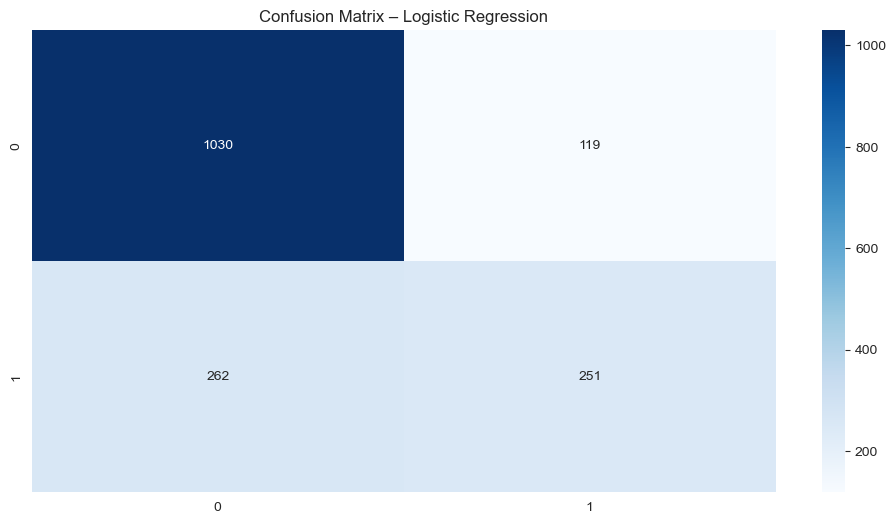


Training Random Forest
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1149
           1       0.68      0.57      0.62       513

    accuracy                           0.78      1662
   macro avg       0.75      0.72      0.73      1662
weighted avg       0.78      0.78      0.78      1662



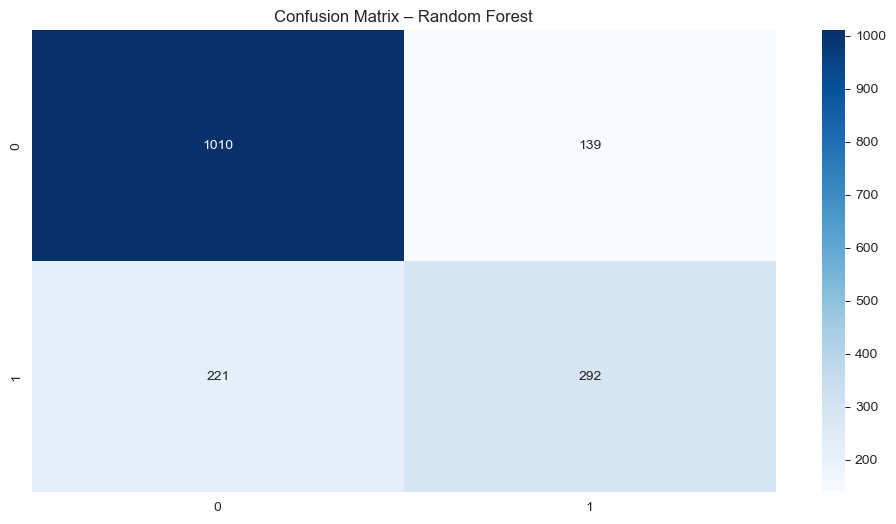


Training KNN
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1149
           1       0.65      0.53      0.58       513

    accuracy                           0.77      1662
   macro avg       0.73      0.70      0.71      1662
weighted avg       0.76      0.77      0.76      1662



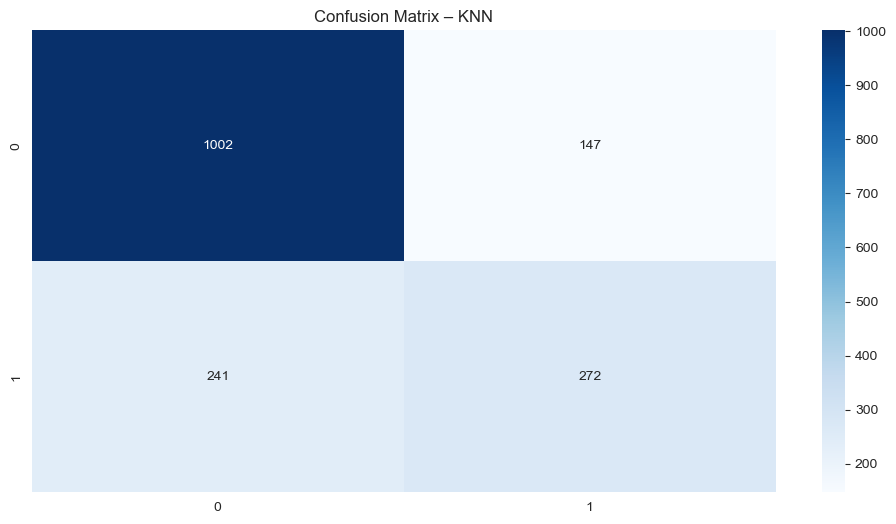


Training SVM
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1149
           1       0.72      0.46      0.56       513

    accuracy                           0.78      1662
   macro avg       0.76      0.69      0.71      1662
weighted avg       0.77      0.78      0.76      1662



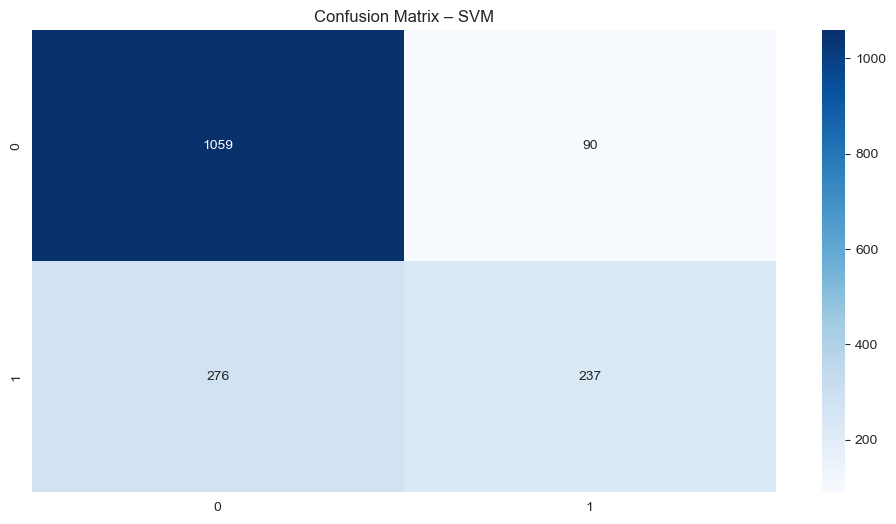

In [16]:
results = []

for name, model in models.items():
    print(f"\nTraining {name}")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

    print(classification_report(y_test, y_pred))

    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True, fmt="d", cmap="Blues"
    )
    plt.title(f"Confusion Matrix – {name}")
    plt.show()


In [17]:
results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
print("\n--- Model Performance Summary ---")
print(results_df)



--- Model Performance Summary ---
                 Model  Accuracy  Precision    Recall        F1
1        Random Forest  0.783394   0.677494  0.569201  0.618644
2                  KNN  0.766546   0.649165  0.530214  0.583691
0  Logistic Regression  0.770758   0.678378  0.489279  0.568516
3                  SVM  0.779783   0.724771  0.461988  0.564286


In [18]:
best_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

best_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Project Geographic '
                                                   'District',
                                                   'Project Budget Amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Project Type',
                                                   'Project Phase Name']),
                                                 ('txt',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=150,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english'))]),
                                                  'Project Description')])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [19]:
def predict_overrun(model):
    print("\nEnter Project Details:\n")

    input_data = {
        "Project Geographic District": int(input("District Number: ")),
        "Project Type": input("Project Type: "),
        "Project Phase Name": input("Phase Name: "),
        "Project Budget Amount": float(input("Budget Amount: ")),
        "Project Description": input("Project Description: ")
    }

    input_df = pd.DataFrame([input_data])

    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]

    if prediction == 1:
        print(f"\nPROJECT WILL OVERRUN (Probability: {probability:.2f})")
    else:
        print(f"\nPROJECT WILL NOT OVERRUN (Probability: {probability:.2f})")